# Build/save classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm
import tikzplotlib as tpl
from datetime import datetime
from IPython.display import display, HTML
import glob

from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split


def _dissonance_data_at_question(dissonances, questions_asked):
    return np.array(
        [np.hstack([d[questions_asked - 1] for d in diss]) for diss in dissonances]
    )


def _diss_dataset(dissonances, questions_asked, groups=["qsampled", "m2"]):
    diss_dataset = pd.concat(
        [
            pd.DataFrame(
                _dissonance_data_at_question(dissonances[group], questions_asked)
            ).assign(y=group)
            for group in groups
        ]
    )
    return diss_dataset

In [5]:
def _train_classifier(diss, groups, questions_asked, quest_order, problem_type):
    data = _diss_dataset(diss, questions_asked, groups=groups)
    data = data.iloc[:, np.r_[:questions_asked, -1]]
    X_train, X_test, y_train, y_test = train_test_split(
        data.drop("y", axis="columns"), data["y"], test_size=0.33
    )

    fig, ax = plt.subplots()

    classifier = RandomForestClassifier(n_jobs=-1)

    classifier.fit(
        X_train.to_numpy(),
        y_train.replace(
            {
                groups[0]: 0,
                groups[1]: 1,
            }
        ),
    )

    classifier.question_order = quest_order

    r = RocCurveDisplay.from_estimator(
        classifier,
        X_test.to_numpy(),
        y_test.replace(
            {
                groups[0]: 0,
                groups[1]: 1,
            }
        ),
        pos_label=1,
        ax=ax,
        name=questions_asked,
    )

    fpr, tpr, thresholds = roc_curve(
        y_test.replace(
            {
                groups[0]: 0,
                groups[1]: 1,
            }
        ),
        classifier.predict_proba(X_test.to_numpy())[:, 1],
        pos_label=1,
    )
    roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds})

    roc_crv = {}
    roc_crv["roc"] = roc_df
    roc_crv["total_samples"] = len(y_train)
    roc_crv["positive_samples"] = len(y_train[y_train == groups[1]])

    pd.to_pickle(
        roc_crv,
        f"deployment-assets/classifiers/{problem_type}-roc-{questions_asked}.pkl",
    )

    pd.to_pickle(
        classifier,
        f"deployment-assets/classifiers/{problem_type}-classifier-{questions_asked}.pkl",
    )

    return classifier

# Global

In [3]:
diss = pd.read_pickle(
    "disson_new/global/dx/disson_global_qmra_missing_0/random_order_disson_1.pkl"
)

quest_order = pd.read_csv(
    "disson_new/global/dx/disson_global_qmra_missing_0/random_order_1.csv"
)["0"]

RandomForestClassifier(n_jobs=-1)

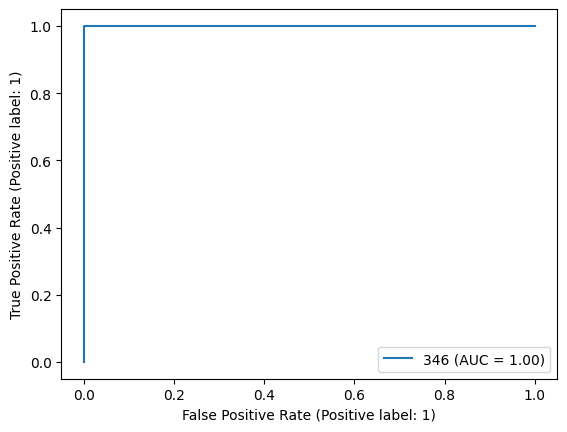

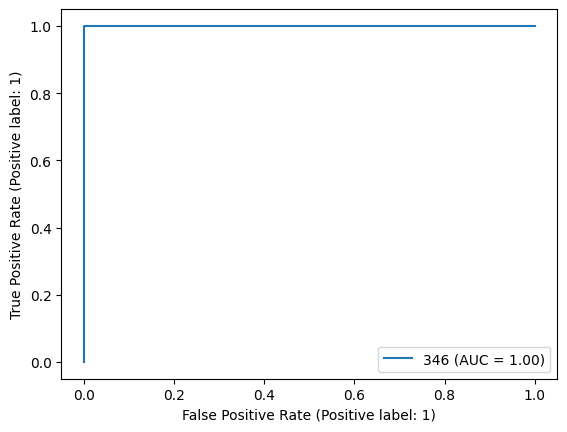

In [10]:
groups = ["actual", "runif"]
problem_type = "global/runif"
questions_asked = 346


_train_classifier(diss, groups, questions_asked, quest_order, problem_type)

groups = ["actual", "m2"]
problem_type = "global/expert"

_train_classifier(diss, groups, questions_asked, quest_order, problem_type)

# PTSD

In [11]:
diss = pd.read_pickle("disson_new/ptsd/dx/disson_ptsd_qmra/random_order_disson_1.pkl")

quest_order = pd.read_csv("disson_new/ptsd/dx/disson_ptsd_qmra/random_order_1.csv")["0"]

RandomForestClassifier(n_jobs=-1)

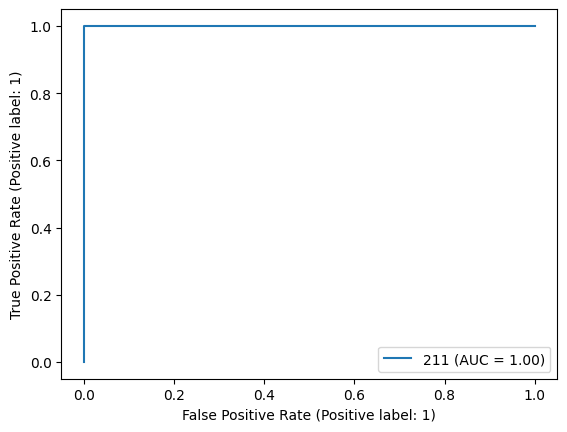

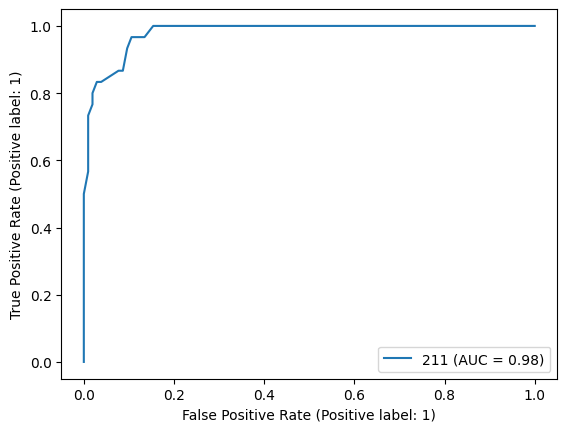

In [12]:
groups = ["actual", "runif"]
problem_type = "ptsd/runif"
questions_asked = 211


_train_classifier(diss, groups, questions_asked, quest_order, problem_type)

groups = ["actual", "m2"]
problem_type = "ptsd/expert"

_train_classifier(diss, groups, questions_asked, quest_order, problem_type)

# Bond

In [13]:
diss = pd.read_pickle(
    "disson_new/bondcourt/core/disson_bond_qmra_missing_0/random_order_disson_0.pkl"
)

quest_order = pd.read_csv(
    "disson_new/bondcourt/core/disson_bond_qmra_missing_0/random_order_0.csv"
)["0"]

RandomForestClassifier(n_jobs=-1)

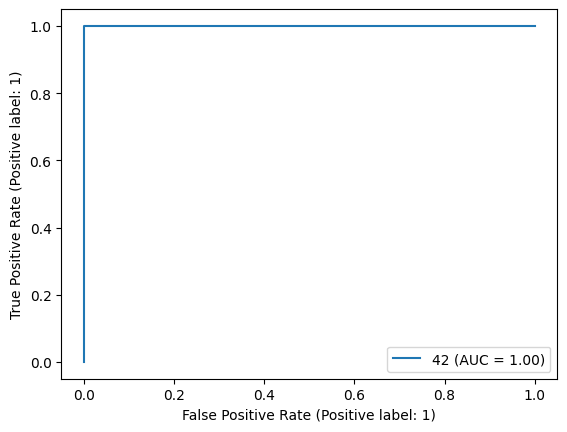

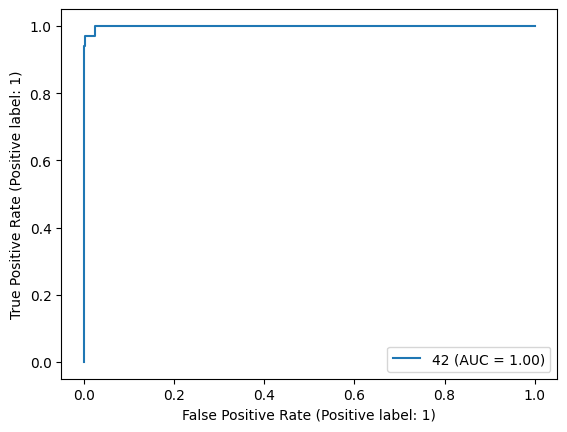

In [17]:
groups = ["actual", "runif"]
problem_type = "bond-court/runif"
questions_asked = 42


_train_classifier(diss, groups, questions_asked, quest_order, problem_type)

groups = ["actual", "m2"]
problem_type = "bond-court/expert"

_train_classifier(diss, groups, questions_asked, quest_order, problem_type)

# Use saved classifier on data

In [8]:
def _diss_linear(s, qnet, missing_value=0):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(1 - Ds[i][s[i]] / np.max(list(Ds[i].values())))
            elif s[i] == "missing":
                diss.append(missing_value)
            else:
                diss.append(1)

    return np.array(diss)


def _actual_sample_dissonance(
    data_sample, diss_models, diss_fcn, order, length, missing_value=0
):
    if order is None:
        order = range(length)

    sample = np.full(length, "", dtype="<U21")

    diss = [list() for model in diss_models]

    # print(data_sample)

    for i in order:
        if data_sample[i] == "":
            sample[i] = "missing"
        else:
            sample[i] = data_sample[i]
        # [print(diss_fcn(sample, model)) for d, model in zip(diss, diss_models)]
        for d, model in zip(diss, diss_models):
            d.append(diss_fcn(sample, model, missing_value))
        # [d.append(diss_fcn(sample, model)) for d, model in zip(diss, diss_models)]

    return sample, diss


def _all_actual_samples_dissonance(
    data_samples, diss_models, diss_fcn, order, length, missing_value=0
):
    samples = list()
    dissonances = list()

    for data_sample in tqdm(data_samples):
        samp, diss = _actual_sample_dissonance(
            data_sample, diss_models, diss_fcn, order, length, missing_value
        )
        # print(len(diss), len(diss[0]), len(diss[0][8]), diss[0][8])
        # print(len(diss), len(diss[0]), len(diss[0][4]), diss[0][4])
        samples.append(samp)
        dissonances.append(diss)

    return samples, dissonances

In [20]:
from quasinet.qnet import load_qnet

diss_models = [
    load_qnet(
        f"disson_new/global/dx/disson_global_qmra_missing_0/random_order_{model}_model_1.joblib.gz",
        gz=True,
    )
    for model in ["full", "neg", "pos"]
]

In [7]:
classifier = pd.read_pickle("tst_classifier.pkl")

In [7]:
data = pd.read_csv("data/gibbons_global/gibbons_global_neg.csv")
data_fmtd = (
    data.iloc[:, classifier.question_order.values]
    .fillna(-9)
    .astype(int)
    .replace(-9, "")
    .to_numpy()
)

In [9]:
pd.to_pickle(data.head(10).to_dict(), "deployment-assets/global-data-example-dict.pkl")

In [21]:
data_diss = _all_actual_samples_dissonance(
    data_fmtd, diss_models, _diss_linear, range(data_fmtd.shape[1]), data_fmtd.shape[1]
)

pd.to_pickle(data_diss, "tst_deploy.pkl")

  0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
data_fmtd.shape

(662, 346)

In [22]:
# data_diss = pd.read_pickle("tst_deploy.pkl")[1]

data_new = pd.DataFrame(_dissonance_data_at_question(data_diss, data_fmtd.shape[1]))

# classifier.predict(data_new)

IndexError: list index out of range